In [1]:
import lightkurve as lk


import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np
# import pandas as pd #optional (may be used in future)

#Needed for r
import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
# print(astropy.__version__)


from transitleastsquares import catalog_info
from transitleastsquares import period_grid
from transitleastsquares import transitleastsquares

import warnings
# warnings.filterwarnings(action='once') #useful to see a warning once but that's it
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

import wotan
from wotan import flatten


from astroML.time_series import lomb_scargle

In [2]:

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]

    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)

In [3]:
#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

data.sort(key=lambda x: int(os.path.basename(x).split('_')[0])) #sorts them in alphanumeric order based on TIC ID (smallest first)

print ("number of files: ",len(data)) #number of files)

1
TESS Sector 01
number of files:  917


## Let's compare with our previous pipeline using Lightkurve's detrending with the new Wotan tools:

See https://github.com/hippke/wotan for more details.


0


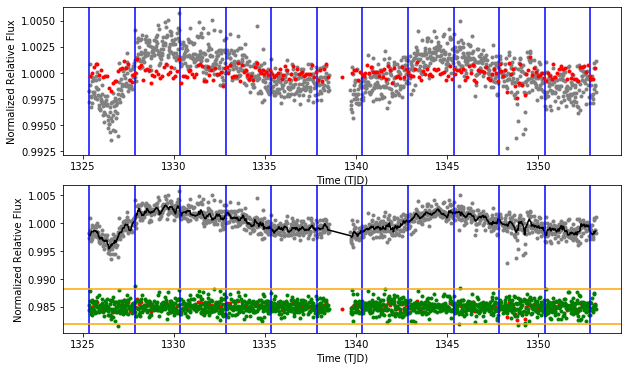

1


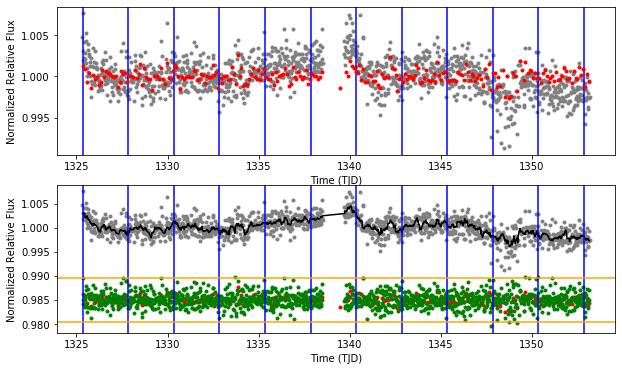

2


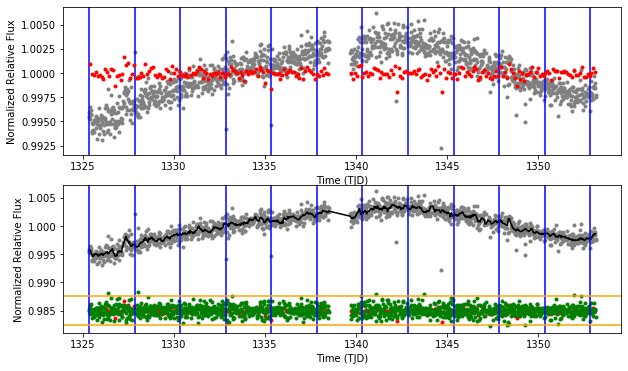

3


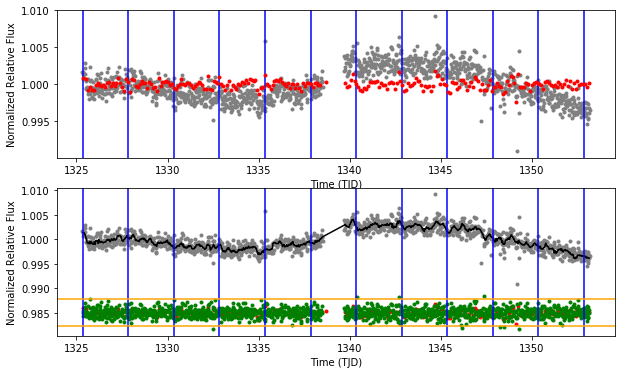

4


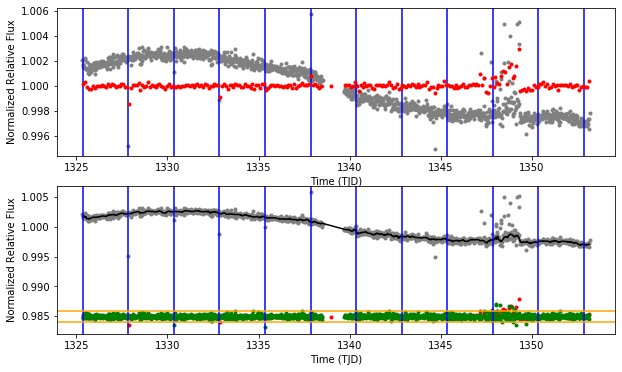

5


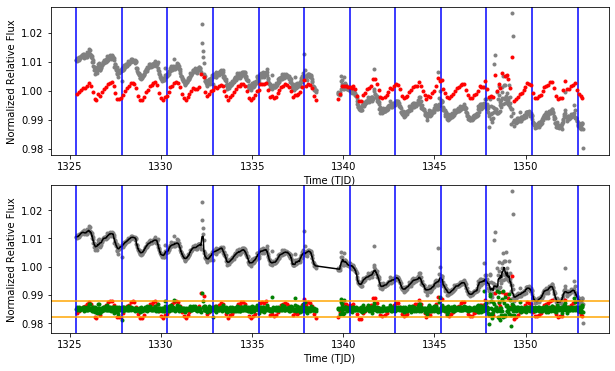

6


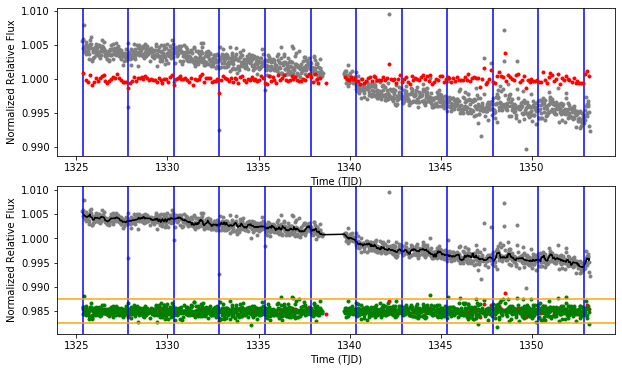

7


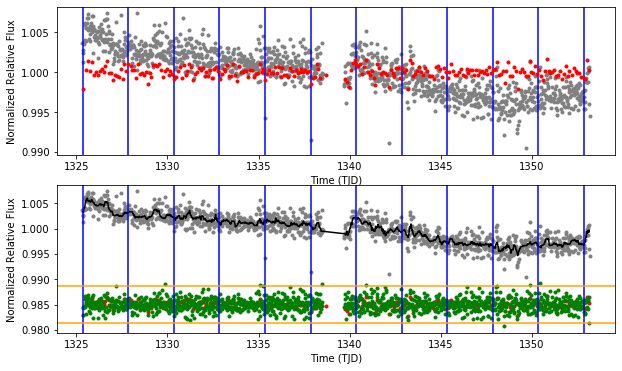

8


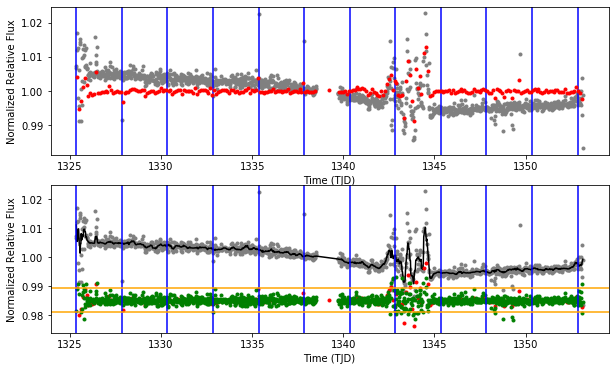

9


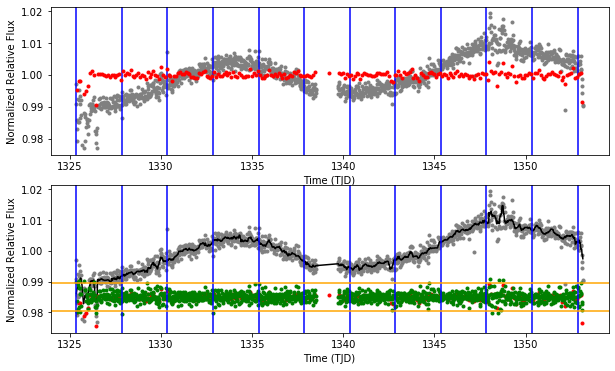

In [4]:
# for ii in range(len(data)): #creating a for loop to show light curve figures for all files
for ii in range(10): #creating a for loop to show light curve figures for all files    
    print(ii)
    time     = np.transpose(np.loadtxt(data[ii]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[ii]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[ii]))[2] #third (zero indexing in python) column 
    
    mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
    time = time[mask]                        #Sometimes there are holes in data filled with NaNs
    mag = mag[mask]
    magerror = magerror[mask]
    
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
    #removing outliers with Chauvenet's criterion
    t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror)
    
    lc = lk.LightCurve(t2,f2,fe2)
    
    bin_size = 5
    cad = time[1]-time[0]
    #now let's define a window size to smooth our data with:

    window_size = int(3.0/cad) #number of data points in 5 hours
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1
        
    detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size)
    
    window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
    flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, method='biweight',robust=True)


    nanmask = np.where(np.isnan(flatten_lc)==False)[0]
    t2 = t2[nanmask]
    f2 = f2[nanmask]
    fe2 =fe2[nanmask]

    flatten_lc = flatten_lc[nanmask]
    trend_lc = trend_lc[nanmask]
#     Try another iteration of outlier removal
    t2_wotan,f2_wotan,fe2_wotan = ChauventsCriteron(t2,flatten_lc,fe2)
    
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(211)
    ax1.plot(lc.time,lc.flux,color='grey',marker='.',linestyle='none')
    for x in range(12):
        plt.axvline(x=(t2[0]+x*2.5),color='b')
    ax1.plot(detrended_lc.time,detrended_lc.flux,color='red',marker='.',linestyle='none')
    ax1.set_xlabel("Time (TJD)")
    ax1.set_ylabel("Normalized Relative Flux")
    
    ax2 = fig.add_subplot(212)
    ax2.plot(lc.time,lc.flux,color='grey',marker='.',linestyle='none')
    ax2.plot(t2,trend_lc,'k')
    offset = 0.015
    ax2.plot(detrended_lc.time,detrended_lc.flux-offset,color='red',marker='.',linestyle='none')
    ax2.plot(t2_wotan,f2_wotan-offset,color='green',marker='.',linestyle='none')
    for x in range(12):
        plt.axvline(x=(t2[0]+x*2.5),color='b')

    plt.axhline(y=np.mean(f2_wotan)+3*np.std(f2_wotan)-offset,color='orange')
    plt.axhline(y=np.mean(f2_wotan)-3*np.std(f2_wotan)-offset,color='orange')
    ax2.set_xlabel("Time (TJD)")
    ax2.set_ylabel("Normalized Relative Flux") 
    plt.show()

## In figures above, the grey and black lines are the undetrended data with modeled trends in black. The green data is our new flattened data and the red data is our old method using LightKurve. The yellow horizontal lines are the mean + 3 standard deviations of the green data. The Blue lines are the 2.5 momentum dump rate for this sector. For most data sets, it appears the outliers due to the momentum dumps are removed. Hopefully, this takes care of that bias in our BLS/TLS results.

## Let's try BLS with these green results. Most 2.5 day momentum dump outliers are minimized but remain, let's see if this is an issue.

In [5]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

SDE Threshold:  7.0


        Use astropy.stats.LombScargle instead. [warnings]


 
iteration 1
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1078 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 
iteration 2
Applying Biweighted Midcorrelation Function...
 
 
iteration 3
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1076 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 9 of 27 transits without data. The true period may be twice the given period.
  warnings.warn(text)


 
iteration 4
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1078 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads
 
iteration 5
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1078 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads
 
file:
TIC  25167696   3   1   Sector01
best period:  5.153871284846246
best T0:  1327.2686747188704


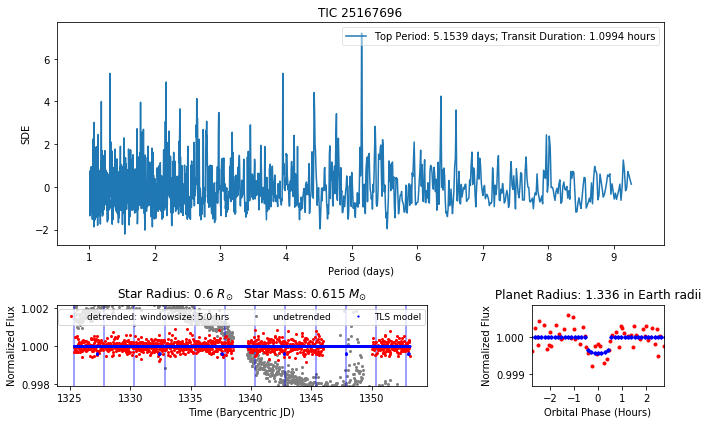


 
iteration 6
Applying Quasi Periodic GP...
 
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([48187.43658447,  2035.76556396, 86095.88988495]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1079 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


        Use astropy.stats.LombScargle instead. [warnings]


 
iteration 7
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1077 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/transitleastsquares/stats.py:456: RuntimeWarning: divide by zero encountered in double_scalars
  snr_pink_per_transit[i] = (1 - mean_flux) / pinknoise


 
iteration 8
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1076 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 
iteration 9
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1052 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads
 
iteration 10
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1065 data points, 1721 periods from 1.01 to 9.257 days
Using all 4 CPU threads
 
iteration 11
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1050 data points, 1716 periods from 1.01 to 9.236 days
Using all 4 CPU threads
 
iteration 12
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1075 data points, 1717 periods from 1.011 to 9.243 days
Using all 4 CPU threads


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 9 of 27 transits without data. The true period may be twice the given period.
  warnings.warn(text)


 
iteration 13
Applying Biweighted Midcorrelation Function...
 
 
iteration 14
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1079 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/transitleastsquares/main.py:404: UserWarning: 10 of 23 transits without data. The true period may be twice the given period.
  warnings.warn(text)


 
iteration 15
Applying Biweighted Midcorrelation Function...
 
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 117 durations
Searching 1077 data points, 1722 periods from 1.011 to 9.264 days
Using all 4 CPU threads
 
file:
TIC  31011838   2   4   Sector01
best period:  1.4300781088530774
best T0:  1325.625526532498


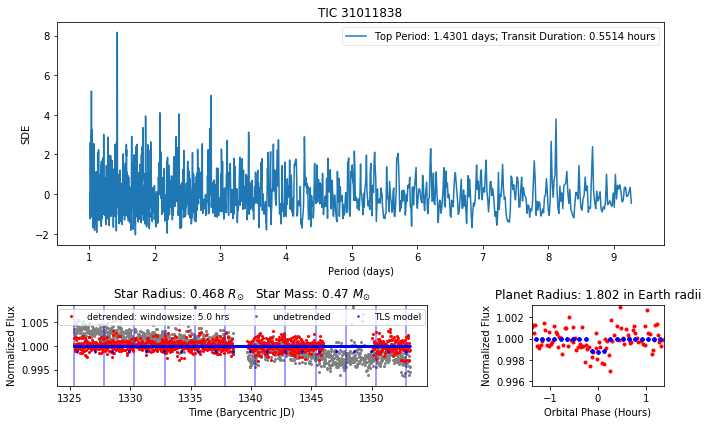

In [51]:
spacing = 0.02

SDE_threshold=7.0

fs = 9
#for reporting TLS model's planet radius
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm


#creating empty lists to be filled then saved for planet candidates
ids=[]
cams=[]
ccds=[]
mstar=[]
rstar=[]
rplanet=[]
per=[]
transdur=[]
sdes=[]

print("SDE Threshold: ", SDE_threshold)
# for ii in range(len(data)): #creating a for loop to show light curve figures for all files
for ii in range(15): #creating a for loop to show light curve figures for all files    
    
    time     = np.transpose(np.loadtxt(data[ii]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[ii]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[ii]))[2] #third (zero indexing in python) column 
    
    mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
    time = time[mask]                        #Sometimes there are holes in data filled with NaNs
    mag = mag[mask]
    magerror = magerror[mask]
    
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
    #known bad data points with high telescope jitter:
    if SectorNum==1:
        jittermask = (time < 1346) | (time > 1350)
    
    #removing outliers with Chauvenet's criterion
    t2,f2,fe2 = ChauventsCriteron(time[jittermask],flux[jittermask],fluxerror[jittermask])
    
    lc = lk.LightCurve(t2,f2,fe2) #outliers removed only
    
    #check for rapid rotators with Lomb-Scargle (P_rot < 2 days)
    period = 10 ** np.linspace(np.log10(0.1), np.log10(3), 1000)
    freq = 2.0 * np.pi / period
    PS = lomb_scargle(t2,f2,fe2,omega=freq, generalized=True)
    Standpower = (PS-np.mean(PS))/np.std(PS)
    print(" ")    
    print("iteration",ii+1)
    
    if period[np.argmax(Standpower)] < 2: #assuming rapid rotators only rotate faster than 2 days

        print("Applying Quasi Periodic GP...")
        print(" ")
        length_scale=2 # 1 to 2 is generally pretty good from my tests
        gpflatten_lc, gptrend_lc = flatten(t2,f2,method='gp', \
                                             kernel='periodic_auto',kernel_size=length_scale,return_trend=True,robust=True)
        
        T=t2
        F= gpflatten_lc
        FE = fe2
    else:

        print("Applying Biweighted Midcorrelation Function...")
        print(" ")
        
        window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
        flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, method='biweight',robust=True)
        T=t2
        F=flatten_lc
        FE=fe2

    #checking for NaNs
    nanmask = np.where(np.isnan(F)==False)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]


#     Try another iteration of outlier removal
    T,F,FE = ChauventsCriteron(T,F,FE)
    
    ID = (os.path.basename(data[ii]).split)('_')[0]


    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.

    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]
    
    
    #doing TLS search:
    
    qld, R_star, R_star_min, R_star_max, M_star, M_star_min, M_star_max = catalog_info(TIC_ID=int(ID))   
    #^^^ grabbing stellar information from MAST catalogs
    
    if np.isfinite(R_star)==True and np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
        minP=1.01
        maxP= (max(T)-min(T))/3.0 #1/3rd length of our light curve to ensure at least 3 transits are fitted
        
        minDur = 1.0/24.0
        maxDur = 5.0/24.0
        durations = np.linspace(minDur,maxDur,25) #not used by TLS, consider toying with dur_gridstep?
        
        #creating list of orbital periods to model with
        periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP)#,oversampling_factor=10)

        
    

        tls = transitleastsquares(T,F,FE)
        tls_power = tls.power(period_min=minP,period_max=maxP,show_progress_bar=False,n_transits_min=3,duration_grid_step=1.02)
        
        #TLS results
        TLS_periods=tls_power.period
        TLS_t0s=tls_power.T0
        TLS_depths=tls_power.depth
        TLS_SDE=tls_power.power
        TLS_Dur = tls_power.duration
        
        #calculating TLS estimated planet radius
        R_p = np.sqrt(1-TLS_depths)*R_star*R_sun/R_earth
        
        #creating the best fit box model to our data
        TLS_model_time = tls_power.model_lightcurve_time 
        TLS_model = tls_power.model_lightcurve_model #results.model_folded_model <--- old
        
        p = TLS_periods
        pf_model = (TLS_model_time - TLS_t0s + 0.5*p) % p - 0.5*p        
        x_fold = (T - TLS_t0s + 0.5*p) % p - 0.5*p
        x_fold_raw = (lc.time - TLS_t0s + 0.5*p) % p - 0.5*p
        
        detrendedphasefoldedlc = [x_fold, F, FE]
        phasefoldedlc = [x_fold_raw, lc.flux, lc.flux_err]


        if len(np.where(TLS_SDE>SDE_threshold)[0])>0:
            print(" ")
            print("file:")
            print("TIC ", ID, " ",CCD, " ",Camera, " ",Sector)
            print("best period: ", TLS_periods)
            print("best T0: ",TLS_t0s)
            
            gs1 = gridspec.GridSpec(3, 3)
            gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


            f = plt.figure(figsize=(10,6))
            ax1 = f.add_subplot(gs1[:-1, :])
            ax2 = f.add_subplot(gs1[-1, :-1])
            ax3 = f.add_subplot(gs1[-1, -1])


            ax1.plot(tls_power.periods, TLS_SDE, rasterized=True,label='Top Period: '+str( np.round(TLS_periods,4) )+" days; Transit Duration: "+str(np.round(24*TLS_Dur,4))+" hours") #rounding period to 4 decimal places 
            plt.xticks(np.arange(0.0, 31.0, 1.0))
            ax1.set_title("TIC "+ ID)
            ax1.set_xlabel("Period (days)")
            ax1.set_xlim(np.min(tls_power.periods)-0.5, np.max(tls_power.periods)+0.5)
            ax1.set_xticks(np.arange(1.0, 10.0, 1.0))
            ax1.set_ylabel("SDE")
            ax1.set_ylim(np.min(TLS_SDE)-0.5, np.max(TLS_SDE)+0.5)
            ax1.legend(loc='best',fancybox=True,framealpha=0.5)
            
            ax2.plot(T, F ,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')#+", binsize: "+str(bin_size)) 
            ax2.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
            ax2.plot(TLS_model_time,TLS_model,'b.',label='TLS model',markersize=2.5)
            ax2.legend(loc='upper center',ncol=3,fontsize=fs)
#             ax2.set_ylim(np.min(f2_wotan)-spacing, np.max(f2_wotan)+spacing) 
            ax2.set_ylim(np.min(F)-5*np.std(F), np.max(F)+5*np.std(F))
            for x in range(12):
                ax2.axvline(x=(T[0]+x*2.5),color='b',alpha=0.5,zorder=0)
#             r'$\alpha 
            ax2.set_title("Star Radius: "+str(np.round(R_star,3))+r" $R_{\odot}$   Star Mass: "+str(np.round(M_star,3))+r" $M_{\odot}$")
            
            ax2.set_xlabel("Time (Barycentric JD)")
            ax2.set_ylabel("Normalized Flux") 

            ax3.plot(24*x_fold,detrendedphasefoldedlc[1],c='red',markersize=6,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+", binsize: "+str(bin_size))
#             ax3.plot(24*x_fold_raw,phasefoldedlc[1],c='grey',marker='.',markersize=6,linestyle='none',zorder=0,label='undetrended')
            ax3.plot(24*pf_model,TLS_model,'b.',label='TLS model',markersize=5)
            ax3.set_xlabel("Orbital Phase (Hours)")
            ax3.set_ylabel("Normalized Flux") 
            ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
#             ax3.set_ylim(np.min(TLS_model)-spacing+0.01, np.max(TLS_model)+spacing-0.01)
            ax3.set_ylim(np.min(TLS_model)-25*np.std(TLS_model), np.max(TLS_model)+25*np.std(TLS_model))
            ax3.set_xticks(np.arange(-10,15,1)) #hours
            ax3.set_xlim(-2.5*TLS_Dur*24,2.5*TLS_Dur*24)
            gs1.tight_layout(f)

            plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_TLS.png")
            plt.show()    
            print( "") #adds space between figures
            
            
            ids.append(ID)
            ccds.append(CCD)
            cams.append(Camera)
            rstar.append(R_star)
            mstar.append(M_star)
            rplanet.append(R_p)
            per.append(TLS_periods)
            transdur.append(TLS_Dur)
            sdes.append(np.max(TLS_SDE))
    else:
        continue
        print(" ") #adds space between figures


In [85]:
ls=np.array([ids,cams,ccds,rstar,mstar,rplanet,per,transdur,sdes]);print(shape(ls))
ls = ls.astype(np.float) #turns strings into floats
lsx = sorted(np.transpose(ls), key=lambda x: x[8],reverse=True) #sort by SDE with highest at top of list
print(lsx)


header='%1s\t%10s\t%1s\t%1s\t%13s\t%15s\t%22s\t%33s\t%10s'%('ids','cams','ccds','rstar','mstar','rplanet','period','transitduration','SDE')
np.savetxt("Sector_01_PlanetCandidates_TLS.txt",lsx,header=header,delimiter='\t',fmt='%s')

(9, 2)
[array([3.10118380e+07, 4.00000000e+00, 2.00000000e+00, 4.68012000e-01,
       4.70359000e-01, 1.80156027e+00, 1.43007811e+00, 2.29766028e-02,
       8.16571563e+00]), array([2.51676960e+07, 1.00000000e+00, 3.00000000e+00, 6.00351000e-01,
       6.15244000e-01, 1.33649650e+00, 5.15387128e+00, 4.58098039e-02,
       7.19868077e+00])]


In [11]:
print("done!")

done!
